Look at Naughten et al 2022 pace-forced ensemble members, and compare to trends in forcing and 1940s event in members.

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from scipy import stats
import cftime
import Functions_data_analysis as fda
import Functions_load_output as flo
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
import matplotlib.path as mpath

In [2]:
naught_dir = '/glade/work/gemmao/Naughten_2022/'
fname = 'MITgcm_AmundsenSeaContinentalShelf_1920-2013_sea_water_potential_temperature_200-700m_PACE'

In [7]:
ens_list = [f'{i:02}' for i in range(1, 21)]
n_ens = len(ens_list)

# get times for plotting all members
ds = xr.open_dataset(naught_dir + fname + ens_list[0] + '.nc')
temp = ds.sea_water_potential_temperature

end_date = 2013 # 2005 (for unbiased PACE winds, stops in 2005) or up to 2013 (if using bias-corrected winds)
time_np = np.arange(1920 + (1/12),end_date,(1/12))
years = np.arange(1920,end_date+1,1)


01: 0.49 degC/cent*
02: 0.35 degC/cent*
03: 0.17 degC/cent*
04: 0.21 degC/cent*
05: 0.08 degC/cent
06: 0.16 degC/cent*
07: 0.38 degC/cent*
08: -0.02 degC/cent
09: 0.18 degC/cent*
10: 0.43 degC/cent*
11: 0.47 degC/cent*
12: 0.43 degC/cent*
13: 0.24 degC/cent*
14: 0.37 degC/cent*
15: 0.70 degC/cent*
16: 0.23 degC/cent*
17: 0.63 degC/cent*
18: 0.25 degC/cent*
19: 0.46 degC/cent*
20: 0.21 degC/cent*
Ensemble mean trend: 0.3201478867087432


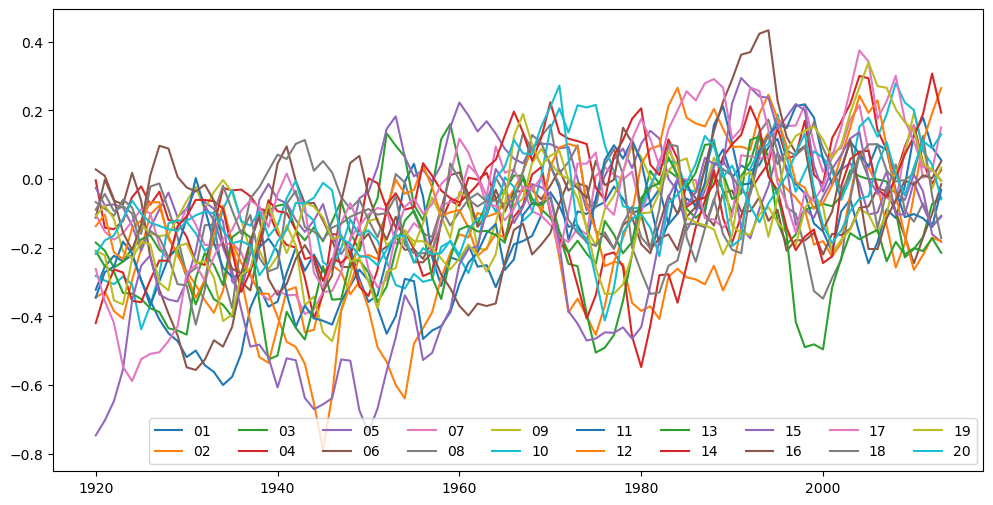

In [4]:
cent_CDW_trends = []
plt.figure(figsize=(12,6))
for i in range(n_ens):
    ens_ds = xr.open_dataset(naught_dir + fname + ens_list[i] + '.nc')
    ens_ds = ens_ds.sel(time=slice('1920',str(end_date)))
    ens_temp = ens_ds.sea_water_potential_temperature
    ens_temp_ann = ens_temp.resample(time='1Y').mean()
    plt.plot(years,ens_temp_ann,label=ens_list[i])
    # calc trend
    slope, intercept, r_value, p_value, std_err = stats.linregress(years, ens_temp_ann)
    if p_value < 0.05:
        sig = '*'
    else:
        sig = ''
    print(ens_list[i] + ': {:.2f} degC/cent'.format(slope*100)+sig)
    cent_CDW_trends.append(slope*100)
plt.legend(ncol=10)

print('Ensemble mean trend:', np.mean(cent_CDW_trends))

In [11]:
# Load (with bias) PACE ensemble and calc 20th century trends

# set up metadata
years = np.arange(1920,2006,1)
ds = xr.open_dataset('/glade/work/gemmao/ASE_winds/PAC_PACE/U/annual_u10_PAC_PACE_ens_01_1920_2005.nc')
pace_lons, pace_lats = ds.lon,ds.lat
n_lats,n_lons = ds.u10.shape[1:]
locs = range(n_lats*n_lons) #192, 288

PACE_u10_trends = np.zeros((n_ens,n_lats,n_lons))
PACE_v10_trends = np.zeros((n_ens,n_lats,n_lons))

for i in range(n_ens):
    print(i)
    #u10
    ds = xr.open_dataset('/glade/work/gemmao/ASE_winds/PAC_PACE/U/annual_u10_PAC_PACE_ens_'+ens_list[i]+'_1920_2005.nc')
    u10 = ds.u10
    u10_rs = u10.values.reshape(len(years),-1) #now it is shape (n_time, nlons*nlats) 
    u10_trends_i = []
    for loc in locs:
        u10_loc = u10_rs[:,loc]
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, u10_loc)
        u10_trends_i.append(slope * 100)
    u10_trends_i = np.array(u10_trends_i)
    u10_trends_i = u10_trends_i.reshape((n_lats,-1))
    PACE_u10_trends[i,:,:] = u10_trends_i

    #v10
    ds = xr.open_dataset('/glade/work/gemmao/ASE_winds/PAC_PACE/V/annual_v10_PAC_PACE_ens_'+ens_list[i]+'_1920_2005.nc')
    v10 = ds.v10
    v10_rs = v10.values.reshape(len(years),-1) #now it is shape (n_time, nlons*nlats) 
    v10_trends_i = []
    for loc in locs:
        v10_loc = v10_rs[:,loc]
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, v10_loc)
        v10_trends_i.append(slope * 100)
    v10_trends_i = np.array(v10_trends_i)
    v10_trends_i = v10_trends_i.reshape((n_lats,-1))
    PACE_v10_trends[i,:,:] = v10_trends_i

print('trends calculated')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
trends calculated


In [6]:
# Set up plotting data for (with bias) PACE data

plot_var = 'v10'
region = 'AS_near'
lat1,lat2,lon1,lon2 = fda.plot_regions[region]

if plot_var == 'v10':
    cmap = 'BrBG'
    levs = np.linspace(-0.5,0.5,11)
    region = 'full_model_domain'
    cbar_label = 'V10 trends [m/s/cent]'
    data_2d = PACE_v10_trends

elif plot_var == 'u10':
    cmap = 'PuOr_r'
    levs = np.linspace(-0.5,0.5,11)
    region = 'full_model_domain'
    cbar_label = 'U10 trends [m/s/cent]'
    data_2d = PACE_u10_trends

#-------------
# quiver data
data_x = PACE_u10_trends
data_y = PACE_v10_trends
vec_len = 0.2

# ice data
land_ice_ds = flo.get_bathymetry_and_troughs()
land_ice_ds_reg = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
ice_lons,ice_lats = land_ice_ds_reg.lon, land_ice_ds_reg.lat

# lons and lats
ds = xr.open_dataset('/glade/work/gemmao/ASE_winds/PAC_PACE/U/annual_u10_PAC_PACE_ens_01_1920_2005.nc')
pace_lons, pace_lats = ds.lon,ds.lat

NameError: name 'PACE_v10_trends' is not defined

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


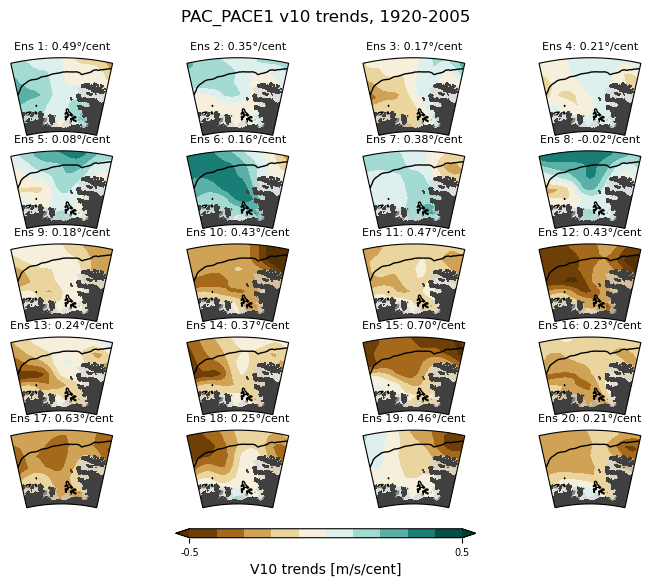

In [26]:
# Plot 20th century trends in raw PACE
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

fig = plt.figure()
fig.set_size_inches((7.5,6))

for i in range(n_ens):

    print(i)
    ax = fig.add_subplot(5,4, i+1, projection=ccrs.SouthPolarStereo(central_longitude=lon_mid)) 
    cf_em = ax.contourf(pace_lons, pace_lats,data_2d[i],transform=grid_proj,
                        levels=levs, cmap=cmap, zorder=0, extend = 'both')
    # plt.annotate(i+1,(0.02,0.9),xycoords='axes fraction',fontsize=8)
    plt.title('Ens '+str(i+1)+': '+'{:.2f}'.format(cent_CDW_trends[i])+'\u00b0'+'/cent',fontsize=8)
    
    # plot quivers
    # smaller scale means longer arrows. smaller regrid = fewer arrows.
    # quiv = ax.quiver(pace_lons,pace_lats, data_x, data_y,
    #                  transform = grid_proj,regrid_shape=500,
    #                  pivot = 'middle',scale=10,width=0.01,
    #                  headlength=3,headaxislength=2.5,
    #                  minshaft=1,edgecolor='white',
    #                  linewidth = 0.2,zorder=3)
    # ax.quiverkey(quiv, X=0.03, Y=0.2, U=vec_len, label=str(vec_len)+' m/s/cent', labelpos='S')
    
    # Plot bathyemtry and ice 
    ax.contour(ice_lons,ice_lats,land_ice_ds_reg.bathy,(1000,),colors='k',transform=grid_proj,linewidths=1,zorder=1)
    ax.contourf(ice_lons,ice_lats,land_ice_ds_reg.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
    ax.contourf(ice_lons,ice_lats,land_ice_ds_reg.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)
    
    # Set shape of map 
    rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
    ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

# Add colorbar
cb_ax = fig.add_axes([0.3,0.1,0.4,0.015])
cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'horizontal')  
cb_em.set_label(label = cbar_label, fontsize=10)
cb_em.ax.tick_params(labelsize=7)
cb_em.set_ticks([levs[0],levs[-1]])
cb_em.set_ticklabels([levs[0],levs[-1]])

plt.suptitle('PAC_PACE1 '+plot_var+ ' trends, 1920-2005')
fig.subplots_adjust(left=0.05,right=0.95,top=0.9,bottom=0.15)


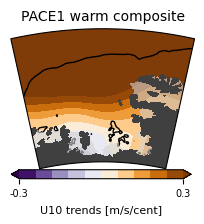

In [12]:
# Set up plotting data for warm or cool composite trends (with bias)

# cmap = 'BrBG'
cmap = 'PuOr_r'
levs = np.linspace(-0.3,0.3,11)
region = 'AS_near'
cbar_label = 'U10 trends [m/s/cent]'
comp = 'warm'


# calculate composite----------------------------------
if comp == 'warm':
    # 5 warm comp members (not indices, but memebrs)
    ens_num_list = [15, 17, 12, 11]#, 1]
else:
    ens_num_list = [8, 9, 5, 4]#, 20]

comp_pace2_list = []
for ens in ens_num_list:
    comp_pace2_list.append(PACE_u10_trends[ens-1])
# mean of warm members
comp_pace2 = np.mean(comp_pace2_list, axis = 0)


# Make plot--------------------------------------------
lat1,lat2,lon1,lon2 = fda.plot_regions[region]
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

fig = plt.figure()
fig.set_size_inches((3,2))
ax = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo(central_longitude=lon_mid)) #eentral_lon =-100 rotates antarctica so pacific is up
cf_em = ax.contourf(pace_lons, pace_lats, comp_pace2,transform=grid_proj,
                    levels=levs, cmap=cmap, zorder=0, extend = 'both')
plt.title('PACE1 '+ comp + ' composite', fontsize=10)
bathy_col = 'k' 
             
# Add colorbar
cb_ax = fig.add_axes([0.22,0.1,0.6,0.045])
cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'horizontal')  
cb_em.set_label(label = cbar_label, fontsize=8)
cb_em.ax.tick_params(labelsize=7)
cb_em.set_ticks([levs[0],levs[-1]])
cb_em.set_ticklabels([levs[0],levs[-1]])

# Plot bathyemtry and ice and plot
land_ice_ds_reg = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
lons,lats = land_ice_ds_reg.lon, land_ice_ds_reg.lat
#blevs = (500,1000)
#ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors=bathy_col,transform=grid_proj,linewidths=1,zorder=1)
# Uncomment to Plot shelf break in thicker line
ax.contour(lons,lats,land_ice_ds_reg.bathy,(1000,),colors=bathy_col,transform=grid_proj,linewidths=1,zorder=1)
ax.contourf(lons,lats,land_ice_ds_reg.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
ax.contourf(lons,lats,land_ice_ds_reg.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)

# Set shape of map to match shape of data rather than a rectangle
rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
rect_in_target = proj_to_data.transform_path(rect)
ax.set_boundary(rect_in_target)
ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

fig.subplots_adjust(left=0.1,right=0.95,top=0.85,bottom=0.15,wspace=0.1,hspace=.05)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


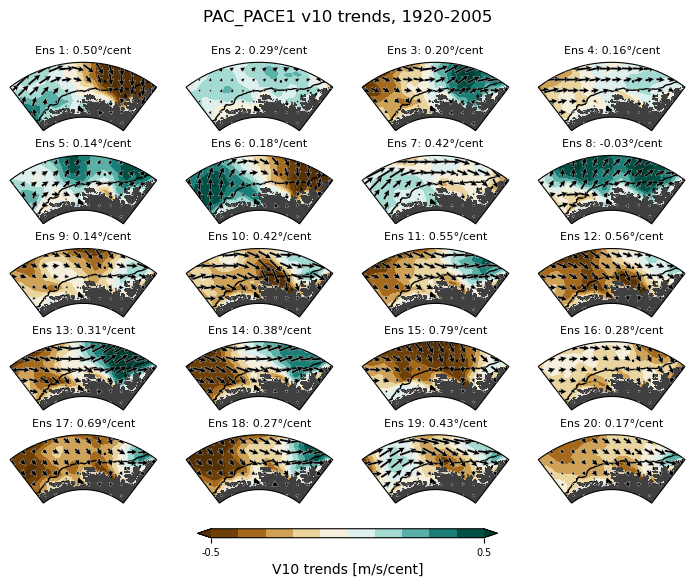

In [13]:
# Plot 20th century trends in PACE with quivers (with bias)
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

fig = plt.figure()
fig.set_size_inches((7.5,6))

for i in range(n_ens):

    print(i)
    ax = fig.add_subplot(5,4, i+1, projection=ccrs.SouthPolarStereo(central_longitude=lon_mid)) 
    cf_em = ax.contourf(pace_lons, pace_lats,data_2d[i],transform=grid_proj,
                        levels=levs, cmap=cmap, zorder=0, extend = 'both')
    plt.title('Ens '+str(i+1)+': '+'{:.2f}'.format(cent_CDW_trends[i])+'\u00b0'+'/cent',fontsize=8)
    
    # plot quivers
    # smaller scale means longer arrows. smaller regrid = fewer arrows.
    quiv = ax.quiver(pace_lons,pace_lats, data_x[i], data_y[i],
                     transform = grid_proj,regrid_shape=400,
                     pivot = 'middle',scale=12,width=0.015,
                     headlength=3,headaxislength=2.5,
                     minshaft=1,edgecolor='white',
                     linewidth = 0.2,zorder=3)
    
    
    # Plot bathyemtry and ice 
    ax.contour(ice_lons,ice_lats,land_ice_ds_reg.bathy,(1000,),colors='k',transform=grid_proj,linewidths=1,zorder=1)
    ax.contourf(ice_lons,ice_lats,land_ice_ds_reg.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
    ax.contourf(ice_lons,ice_lats,land_ice_ds_reg.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)
    
    # Set shape of map 
    rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
    ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

# Add colorbar
cb_ax = fig.add_axes([0.3,0.1,0.4,0.015])
cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'horizontal')  
cb_em.set_label(label = cbar_label, fontsize=10)
cb_em.ax.tick_params(labelsize=7)
cb_em.set_ticks([levs[0],levs[-1]])
cb_em.set_ticklabels([levs[0],levs[-1]])

# ax.quiverkey(quiv, X=0.03, Y=0.2, U=vec_len, label=str(vec_len)+' m/s/cent', labelpos='S')

plt.suptitle('PAC_PACE1 '+plot_var+ ' trends, 1920-2005')
fig.subplots_adjust(left=0.05,right=0.95,top=0.9,bottom=0.15)


In [8]:
# Plot bathyemtry and ice and plot
region = 'AS_near'
lat1,lat2,lon1,lon2 = fda.plot_regions[region]
land_ice_ds = flo.get_bathymetry_and_troughs()
land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
ice_lons,ice_lats = land_ice_ds.lon, land_ice_ds.lat


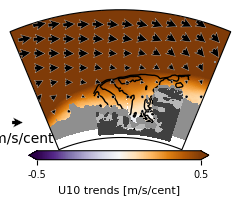

In [9]:
# plot bias-corrected trends: testing one member

cmap = 'PuOr_r'
levs = np.linspace(-0.5,.5,11)
cbar_label = 'U10 trends [m/s/cent]'
lat1,lat2,lon1,lon2 = fda.plot_regions['AS_long']
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

u_ds = xr.open_dataset(naught_dir + 'MITgcm_AmundsenSea_1920-2013_trend_in_eastward_wind_PACE.nc')
u_ds = u_ds.sel(X=slice(lon1,lon2),Y=slice(lat2,lat1))
naught_uwind_trends = u_ds['trend_in_eastward_wind'] #shape (20 mems, 384 lats, 600 lons, but dims are labeled "time", "Y", and "X" )
v_ds = xr.open_dataset(naught_dir + 'MITgcm_AmundsenSea_1920-2013_trend_in_northward_wind_PACE.nc')
v_ds = v_ds.sel(X=slice(lon1,lon2),Y=slice(lat2,lat1))
naught_vwind_trends = v_ds['trend_in_northward_wind'] 
cent_uwind_trends = naught_uwind_trends*100
cent_vwind_trends = naught_vwind_trends*100
naught_lons,naught_lats = naught_uwind_trends.X, naught_uwind_trends.Y



fig = plt.figure()
fig.set_size_inches((3,2))

ax = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo(central_longitude=lon_mid)) #central_lon =-100 rotates antarctica so pacific is up

#mask large arrows incorrectly plotly
wind_mag = (cent_uwind_trends ** 2 + cent_vwind_trends ** 2) ** 0.5
uwind_masked = cent_uwind_trends.where(wind_mag < 1e39) # mask large values where ice is
vwind_masked = cent_vwind_trends.where(wind_mag <1e39)
cf_em = ax.pcolormesh(naught_lons, naught_lats, uwind_masked[0],vmin=-0.5,vmax=0.5,transform=grid_proj,cmap=cmap, zorder=0)
quiv = ax.quiver(naught_lons, naught_lats, uwind_masked[0], vwind_masked[0],
                     transform = grid_proj,regrid_shape=10,
                     pivot = 'middle',scale=20,width=0.015,
                     headlength=3,headaxislength=2.5,
                     minshaft=1,edgecolor='white',
                     linewidth = 0.2,zorder=3)
vec_len = 1
ax.quiverkey(quiv, X=0.03, Y=0.2, U=vec_len, label=str(vec_len)+' m/s/cent', labelpos='S')

# show gray where ice is (naughton ice doesn't perfectly align with ours)
ice_locs = cent_uwind_trends[0].where(wind_mag[0] > 1e39)
ax.contourf(naught_lons,naught_lats,ice_locs,transform=grid_proj,cmap='gray',zorder=2)
# Plot bathyemtry and ice and plot
land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
lons,lats = land_ice_ds.lon, land_ice_ds.lat
blevs = (500,1000)
ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors='k',transform=grid_proj,linewidths=1,zorder=1)
ax.contourf(lons,lats,land_ice_ds.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
ax.contourf(lons,lats,land_ice_ds.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)


# Add colorbar
cb_ax = fig.add_axes([0.22,0.1,0.6,0.045])
cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'horizontal')  
cb_em.set_label(label = cbar_label, fontsize=8)
cb_em.ax.tick_params(labelsize=7)
cb_em.set_ticks([levs[0],levs[-1]])
cb_em.set_ticklabels([levs[0],levs[-1]])


# Set shape of map to match shape of data rather than a rectangle
rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
rect_in_target = proj_to_data.transform_path(rect)
ax.set_boundary(rect_in_target)
ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())


fig.subplots_adjust(left=0.1,right=0.95,top=0.85,bottom=0.15,wspace=0.1,hspace=.05)


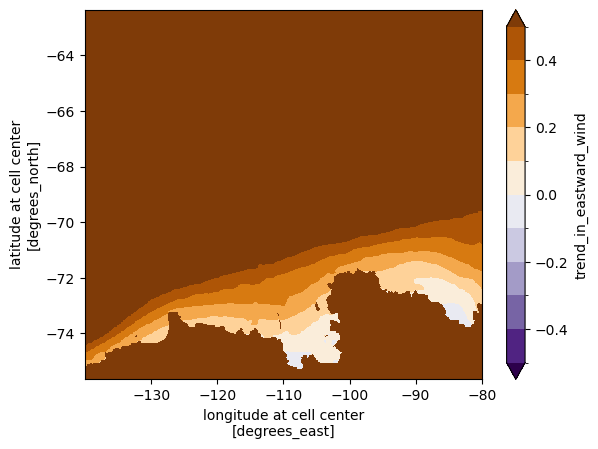

In [43]:
fname_var='northward_wind'
ds = xr.open_dataset(naught_dir + 'MITgcm_AmundsenSea_1920-2013_trend_in_'+fname_var+'_wind_PACE.nc')
naught_wind_trends = ds['trend_in_'+fname_var+'_wind']
test = naught_wind_trends[1]*100
test.plot.pcolormesh(levels=levs,cmap=cmap,extend='both')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


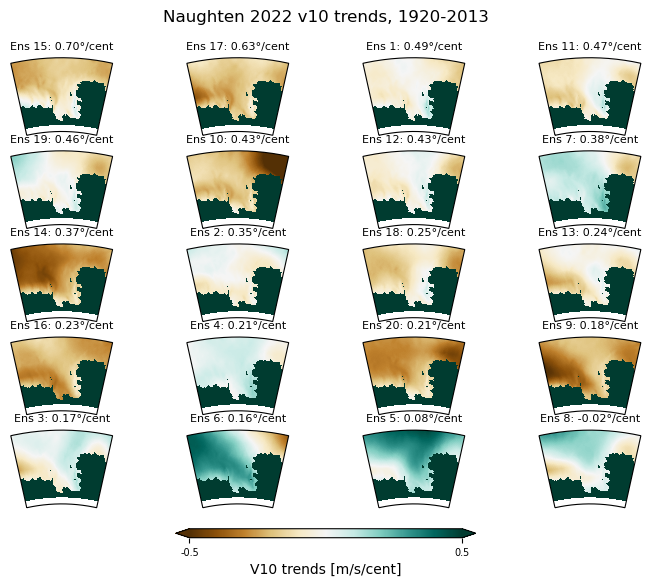

In [44]:
# Plot full ensemble of bias-corrected winds from Naughten 2022 

plot_var = 'v10'
region = 'AS_near'
lat1,lat2,lon1,lon2 = fda.plot_regions[region]

if plot_var == 'v10':
    cmap = 'BrBG'
    levs = np.linspace(-0.5,0.5,11)
    cbar_label = 'V10 trends [m/s/cent]'
    fname_var = 'northward_wind'

elif plot_var == 'u10':
    cmap = 'PuOr_r'
    levs = np.linspace(-0.5,.5,11)
    fname_var = 'eastward_wind'
    cbar_label = 'U10 trends [m/s/cent]'

elif plot_var == 'tas':
    cmap = 'PiYG'
    levs = np.linspace(-3.5,3.5,11)
    fname_var = 'air_temperature'
    cbar_label = 'U10 trends [m/s/cent]'

ds = xr.open_dataset(naught_dir + 'MITgcm_AmundsenSea_1920-2013_trend_in_'+fname_var+'_PACE.nc')
naught_wind_trends = ds['trend_in_'+fname_var] #shape (20 mems, 384 lats, 600 lons, but dims are labeled "time", "Y", and "X" )
naught_lons,naught_lats = naught_wind_trends.X, naught_wind_trends.Y

lat1,lat2,lon1,lon2 = fda.plot_regions[region]
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

# order plots from warmest ens to coolest ens
indices_descending = sorted(range(len(cent_CDW_trends)), key=lambda i: cent_CDW_trends[i], reverse=True)
fig = plt.figure()
fig.set_size_inches((7.5,6))
i = 0
for i in range(20):
    print(i)
    ens_num = indices_descending[i]
    ax = fig.add_subplot(5,4, i+1, projection=ccrs.SouthPolarStereo(central_longitude=lon_mid)) 
    # cf_em = ax.contourf(naught_lons, naught_lats, naught_wind_trends[ens_num]*100, transform=grid_proj,levels=levs, cmap=cmap, zorder=0, extend = 'both')
    cf_em = ax.pcolormesh(naught_lons, naught_lats, naught_wind_trends[ens_num]*100,vmin=-0.5,vmax=0.5,transform=grid_proj,cmap=cmap, zorder=0)

    # # Set shape of map 
    rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
    ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())

    plt.title('Ens '+str(ens_num+1)+': '+'{:.2f}'.format(cent_CDW_trends[ens_num])+'\u00b0'+'/cent',fontsize=8)

    # gl = ax.gridlines(crs=grid_proj, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    i += 1
    
# Add colorbar
cb_ax = fig.add_axes([0.3,0.1,0.4,0.015])
cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'horizontal')  
cb_em.set_label(label = cbar_label, fontsize=10)
cb_em.ax.tick_params(labelsize=7)
cb_em.set_ticks([levs[0],levs[-1]])
cb_em.set_ticklabels([levs[0],levs[-1]])

plt.suptitle('Naughten 2022 '  +plot_var + ' trends, 1920-2013')
fig.subplots_adjust(left=0.05,right=0.95,top=0.9,bottom=0.15)


In [ ]:
# calculate bias-corrected naughten t, u, and v trends---------------

# 2m air temp
ds = xr.open_dataset(naught_dir + 'MITgcm_AmundsenSea_1920-2013_trend_in_air_temperature_PACE.nc')
naught_tas_trends = ds['trend_in_air_temperature'] #shape (20 mems, 384 lats, 600 lons, but dims are labeled "time", "Y", and "X" )

# uwinds
ds = xr.open_dataset(naught_dir + 'MITgcm_AmundsenSea_1920-2013_trend_in_eastward_wind_PACE.nc')
naught_uwind_trends = ds['trend_in_eastward_wind'] #shape (20 mems, 384 lats, 600 lons, but dims are labeled "time", "Y", and "X" )
naught_lons,naught_lats = naught_uwind_trends.X, naught_uwind_trends.Y

# vwinds
ds = xr.open_dataset(naught_dir + 'MITgcm_AmundsenSea_1920-2013_trend_in_northward_wind_PACE.nc')
naught_vwind_trends = ds['trend_in_northward_wind'] 

# enter how many members to warmosite 
n_comp_mems = 4

In [28]:
# calculate warm composite----------------------------------

# order plots from warmest ens to coolest ens base on CDW trends
indices_descending = sorted(range(len(cent_CDW_trends)), key=lambda i: cent_CDW_trends[i], reverse=True)
ens_idx_list = indices_descending[0:n_comp_mems]
print('warm composite indexes (NOT member numbers, but indexes):',ens_idx_list)

# build composite array
n_lats,n_lons = len(naught_lats), len(naught_lons)
warm_tas_trend_arr = np.zeros((n_comp_mems,n_lats,n_lons))
warm_uwind_trend_arr = np.zeros((n_comp_mems,n_lats,n_lons))
warm_vwind_trend_arr = np.zeros((n_comp_mems,n_lats,n_lons))
i = 0
for ens_idx in ens_idx_list:
    print(i)
    warm_tas_trend_arr[i] = naught_tas_trends[ens_idx]*100 #from per yr to per cent
    warm_uwind_trend_arr[i] = naught_uwind_trends[ens_idx]*100 
    warm_vwind_trend_arr[i] = naught_vwind_trends[ens_idx]*100
    i += 1
    
# mean of warm members
warm_naught_tas_trends = np.mean(warm_tas_trend_arr, axis = 0)
warm_naught_uwind_trends = np.mean(warm_uwind_trend_arr, axis = 0)
warm_naught_vwind_trends = np.mean(warm_vwind_trend_arr, axis = 0)



warm warmosite indexes (NOT member numbers, but indexes): [14, 16, 0, 10]
0
1
2
3


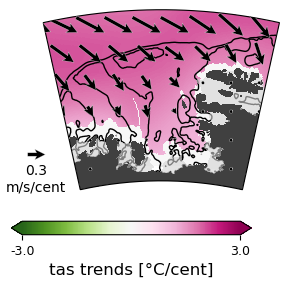

In [40]:
# plot bias-corrected trends warm composite

region = 'AS_near'
plot_var = 'tas'
cbar_label = plot_var+' trends [°C/cent]'
levs = np.linspace(-3,3,11)


# plot------------------------------------------------
lat1,lat2,lon1,lon2 = fda.plot_regions[region]
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

fig = plt.figure()
fig.set_size_inches((6,3))
ax = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo(central_longitude=lon_mid))

#mask large values where ice is 
warm_tas_masked = np.where(warm_naught_tas_trends > 1e30, np.ma.masked, warm_naught_tas_trends)
warm_uwind_masked = np.where(warm_naught_uwind_trends > 1e30, np.ma.masked, warm_naught_uwind_trends)
warm_vwind_masked = np.where(warm_naught_vwind_trends > 1e30, np.ma.masked, warm_naught_vwind_trends)
if plot_var == 'v10':
    cf_em = ax.pcolormesh(naught_lons, naught_lats, warm_vwind_masked,vmin=-0.5,vmax=0.5,transform=grid_proj,cmap=cmap, zorder=0)
elif plot_var == 'u10':
    cf_em = ax.pcolormesh(naught_lons, naught_lats, warm_uwind_masked,vmin=-0.5,vmax=0.5,transform=grid_proj,cmap=cmap, zorder=0)
elif plot_var == 'tas':
    cf_em = ax.pcolormesh(naught_lons, naught_lats, warm_tas_masked,vmin=-3,vmax=3,transform=grid_proj,cmap='PiYG_r', zorder=0)
quiv = ax.quiver(naught_lons, naught_lats, warm_uwind_masked, warm_vwind_masked,
                     transform = grid_proj,regrid_shape=16,
                     pivot = 'middle',scale=4,width=0.015,
                     headlength=3,headaxislength=2.5,
                     minshaft=1,edgecolor='white',
                     linewidth = 0.2,zorder=3)
vec_len = 0.3
ax.quiverkey(quiv, X=-0.03, Y=0.2, U=vec_len, label=str(vec_len)+'\nm/s/cent', labelpos='S')

# Plot bathyemtry and ice and plot
land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
lons,lats = land_ice_ds.lon, land_ice_ds.lat
blevs = (500,1000)
ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors='k',transform=grid_proj,linewidths=1,zorder=1)
ax.contourf(lons,lats,land_ice_ds.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
ax.contourf(lons,lats,land_ice_ds.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)


# Add colorbar
cb_ax = fig.add_axes([0.3,0.1,0.4,0.045])
cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'horizontal')  
cb_em.set_label(label = cbar_label, fontsize=12)
cb_em.ax.tick_params(labelsize=9)
cb_em.set_ticks([levs[0],levs[-1]])
cb_em.set_ticklabels([levs[0],levs[-1]])


# Set shape of map to match shape of data rather than a rectangle
rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
rect_in_target = proj_to_data.transform_path(rect)
ax.set_boundary(rect_in_target)
ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())


fig.subplots_adjust(left=0.15,right=0.95,top=0.85,bottom=0.25,wspace=0.1,hspace=.05)


In [41]:
# calculate bias-corrected cool composite----------------------------------

# order plots from warmest ens to coolest ens base on CDW trends
indices_descending = sorted(range(len(cent_CDW_trends)), key=lambda i: cent_CDW_trends[i], reverse=True)
ens_idx_list = indices_descending[-n_comp_mems:] 
print('cool_composite indexes (NOT member numbers, but indexes):',ens_idx_list)

# build composite array
n_lats,n_lons = len(naught_lats), len(naught_lons)
cool_tas_trend_arr = np.zeros((n_comp_mems,n_lats,n_lons))
cool_uwind_trend_arr = np.zeros((n_comp_mems,n_lats,n_lons))
cool_vwind_trend_arr = np.zeros((n_comp_mems,n_lats,n_lons))
i = 0
for ens_idx in ens_idx_list:
    print(i)
    cool_tas_trend_arr[i] = naught_tas_trends[ens_idx]*100 #from per yr to per cent
    cool_uwind_trend_arr[i] = naught_uwind_trends[ens_idx]*100 
    cool_vwind_trend_arr[i] = naught_vwind_trends[ens_idx]*100
    i += 1
    
# mean of cool members
cool_naught_tas_trends = np.mean(cool_tas_trend_arr, axis = 0)
cool_naught_uwind_trends = np.mean(cool_uwind_trend_arr, axis = 0)
cool_naught_vwind_trends = np.mean(cool_vwind_trend_arr, axis = 0)



cool_composite indexes (NOT member numbers, but indexes): [2, 5, 4, 7]
0
1
2
3


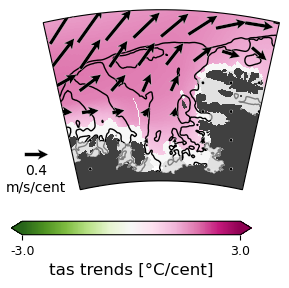

In [45]:
# plot bias-corrected trends cool composite

region = 'AS_near'
plot_var = 'tas'
cbar_label = plot_var+' trends [°C/cent]'
levs = np.linspace(-3,3,11)


# plot------------------------------------------------
lat1,lat2,lon1,lon2 = fda.plot_regions[region]
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

fig = plt.figure()
fig.set_size_inches((6,3))
ax = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo(central_longitude=lon_mid))

#mask large values where ice is 
cool_tas_masked = np.where(cool_naught_tas_trends > 1e30, np.ma.masked, cool_naught_tas_trends)
cool_uwind_masked = np.where(cool_naught_uwind_trends > 1e30, np.ma.masked, cool_naught_uwind_trends)
cool_vwind_masked = np.where(cool_naught_vwind_trends > 1e30, np.ma.masked, cool_naught_vwind_trends)
if plot_var == 'v10':
    cf_em = ax.pcolormesh(naught_lons, naught_lats, cool_vwind_masked,vmin=-0.5,vmax=0.5,transform=grid_proj,cmap=cmap, zorder=0)
elif plot_var == 'u10':
    cf_em = ax.pcolormesh(naught_lons, naught_lats, cool_uwind_masked,vmin=-0.5,vmax=0.5,transform=grid_proj,cmap=cmap, zorder=0)
elif plot_var == 'tas':
    cf_em = ax.pcolormesh(naught_lons, naught_lats, cool_tas_masked,vmin=-3,vmax=3,transform=grid_proj,cmap='PiYG_r', zorder=0)
quiv = ax.quiver(naught_lons, naught_lats, cool_uwind_masked, cool_vwind_masked,
                     transform = grid_proj,regrid_shape=16,
                     pivot = 'middle',scale=4,width=0.015,
                     headlength=3,headaxislength=2.5,
                     minshaft=1,edgecolor='white',
                     linewidth = 0.2,zorder=3)
vec_len = 0.4
ax.quiverkey(quiv, X=-0.03, Y=0.2, U=vec_len, label=str(vec_len)+'\nm/s/cent', labelpos='S')

# Plot bathyemtry and ice and plot
land_ice_ds = land_ice_ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
lons,lats = land_ice_ds.lon, land_ice_ds.lat
blevs = (500,1000)
ax.contour(lons,lats,land_ice_ds.bathy,blevs,colors='k',transform=grid_proj,linewidths=1,zorder=1)
ax.contourf(lons,lats,land_ice_ds.all_ice,transform=grid_proj,colors=['lightgray']*2,alpha=0.6,zorder=2)
ax.contourf(lons,lats,land_ice_ds.grounded_ice,transform=grid_proj,cmap='binary_r',zorder=2)


# Add colorbar
cb_ax = fig.add_axes([0.3,0.1,0.4,0.045])
cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'horizontal')  
cb_em.set_label(label = cbar_label, fontsize=12)
cb_em.ax.tick_params(labelsize=9)
cb_em.set_ticks([levs[0],levs[-1]])
cb_em.set_ticklabels([levs[0],levs[-1]])


# Set shape of map to match shape of data rather than a rectangle
rect = mpath.Path([[lon1, lat2], [lon2, lat2],[lon2, lat1], [lon1, lat1], [lon1, lat2]]).interpolated(50)
proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
rect_in_target = proj_to_data.transform_path(rect)
ax.set_boundary(rect_in_target)
ax.set_xlim(rect_in_target.vertices[:,0].min(), rect_in_target.vertices[:,0].max())
ax.set_ylim(rect_in_target.vertices[:,1].min(), rect_in_target.vertices[:,1].max())


fig.subplots_adjust(left=0.15,right=0.95,top=0.85,bottom=0.25,wspace=0.1,hspace=.05)


In [15]:
# Plot sea ice area trends
naught_dir = '/glade/work/gemmao/Naughten_2022/'
fname = 'MITgcm_AmundsenSea_1920-2013_trend_in_sea_ice_area_fraction_PACE.nc'

si_ds = xr.open_dataset(naught_dir+fname)
si_trends = si_ds.trend_in_sea_ice_area_fraction
si_trends.shape

(20, 384, 600)

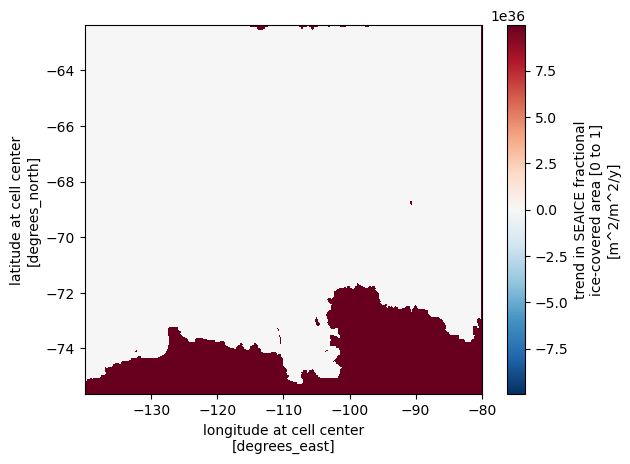

In [30]:
si_trends[1,:,:].plot()

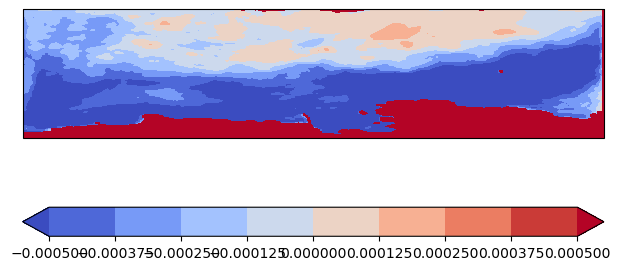

In [44]:
lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

fig = plt.figure()
fig.set_size_inches((7.5,6))
ax = fig.add_subplot(1,1, i+1, projection=ccrs.SouthPolarStereo(central_longitude=lon_mid)) 
si_lons,si_lats = si_trends.X,si_trends.Y
cf_em = ax.contourf(si_lons, si_lats,si_trends[0],
                        levels=np.linspace(-0.0005,0.0005,9), cmap='coolwarm', zorder=0, extend = 'both')
cb_em = fig.colorbar(cf_em, extend='both',orientation = 'horizontal')  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


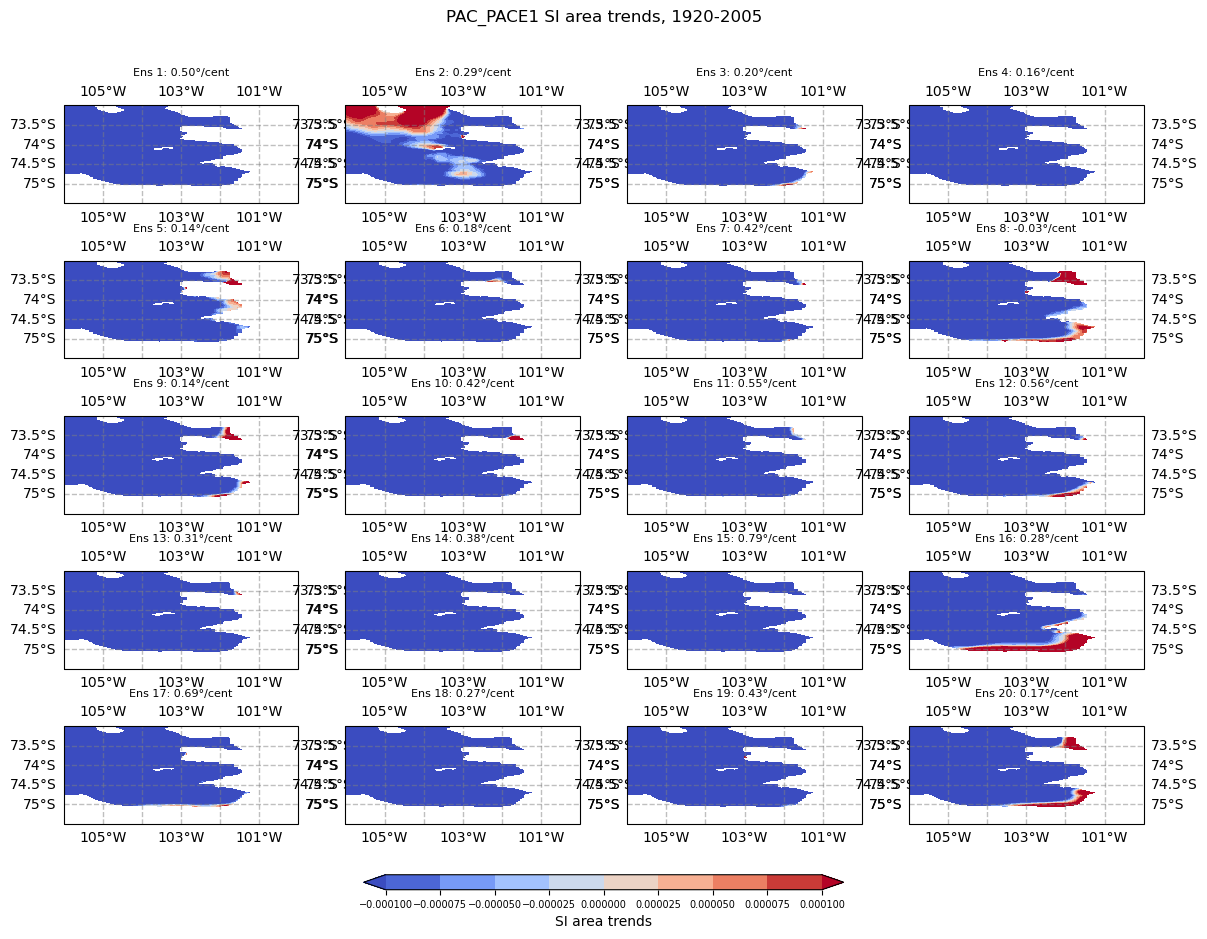

In [66]:
# Plot 20th century trends in PACE

# plotting bathymetry and setting map shape doesn't work with Kaitlin's grid

lon_mid = (lon1+lon2)/2
grid_proj = ccrs.PlateCarree()

fig = plt.figure()
fig.set_size_inches((12,10))
si_lons,si_lats = si_trends[0].X,si_trends[0].Y

for i in range(n_ens):

    print(i)
    ax = fig.add_subplot(5,4, i+1, projection=grid_proj) 
    si_trends_mask = si_trends[i].where(si_trends[i] <= 1, drop=False)
    cf_em = ax.contourf(si_lons, si_lats,si_trends_mask,transform=grid_proj,
                        levels=np.linspace(-0.0001,0.0001,9), cmap='coolwarm', zorder=0, extend = 'both')
    # plt.annotate(i+1,(0.02,0.9),xycoords='axes fraction',fontsize=8)
    plt.title('Ens '+str(i+1)+': '+'{:.2f}'.format(cent_CDW_trends[i])+'\u00b0'+'/cent',fontsize=8)
    ax.set_extent([-106, -100, -75.5, -73])  # Adjust the extent as needed

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')


# Add colorbar
cb_ax = fig.add_axes([0.3,0.1,0.4,0.015])
cb_em = fig.colorbar(cf_em, cax=cb_ax, extend='both',orientation = 'horizontal')  
cb_em.set_label(label = 'SI area trends', fontsize=10)
cb_em.ax.tick_params(labelsize=7)

plt.suptitle('PAC_PACE1 SI area trends, 1920-2013')
fig.subplots_adjust(left=0.05,right=0.95,top=0.9,bottom=0.15)
